In [76]:
import numpy as np
from csv_utils import load_model_data
import matplotlib.pyplot as plt
plt.rcParams.update({
    "figure.figsize": (10, 6),
    "text.usetex": False, # Remove this line if your code doesn't run/ take too long
    # "font.family": 'Times New Roman',
    "figure.dpi": 100,
    "font.size": 14
})
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

In [77]:
csv_file = 'data.csv'
full_data = load_model_data(csv_file,load_gauge_fidelity=True)

In [78]:
import numpy as np

# Convert to numpy
F_naive = np.array(full_data['model_average_fidelity'])
F = np.array(full_data['model_average_fidelity_gauge'])
P = np.array(full_data['P_vector'], dtype=object)

# ---- 1. FILTER FIRST ----
# mask = F > 0.85

# F_naive = F_naive[mask]
# F = F[mask]
# P = P[mask]

# ---- 2. SHUFFLE ----
n = len(F)
perm = np.random.permutation(n)

F_naive = F_naive[perm]
F = F[perm]
P = P[perm]

# ---- 3. SPLIT ----
split = int(0.7 * n)

F_naive_train, F_naive_test = F_naive[:split], F_naive[split:]
F_train, F_test = F[:split], F[split:]
P_train, P_test = P[:split], P[split:]

# ---- 4. (Optional) back to lists ----
F_naive_train = F_naive_train.tolist()
F_naive_test  = F_naive_test.tolist()
F_train = F_train.tolist()
F_test  = F_test.tolist()
P_train = P_train.tolist()
P_test  = P_test.tolist()


In [79]:
P_avg = [sum(pvector)/3 for pvector in P]

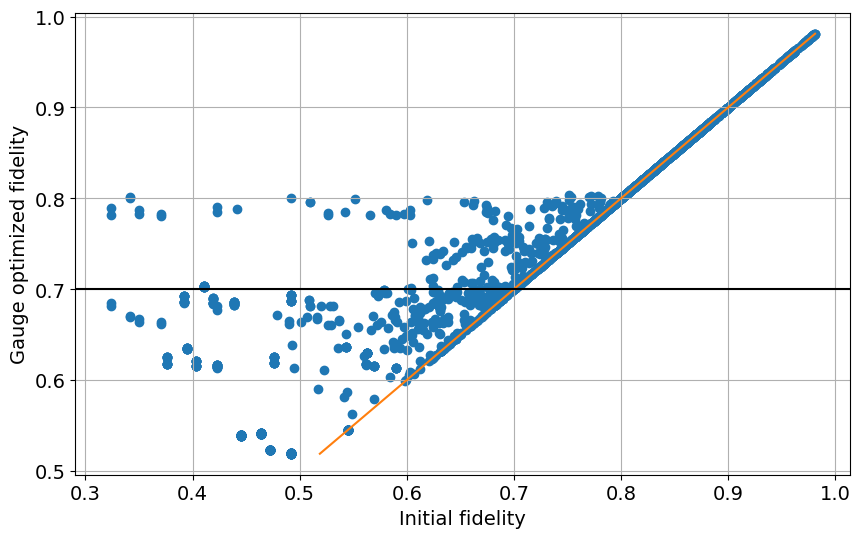

In [80]:
plt.scatter(F_naive,F)
plt.plot([min(F),max(F)],[min(F),max(F)],color = 'C1')
plt.xlabel('Initial fidelity')
plt.ylabel('Gauge optimized fidelity')
plt.grid()
plt.axhline(y=0.7,color='k')

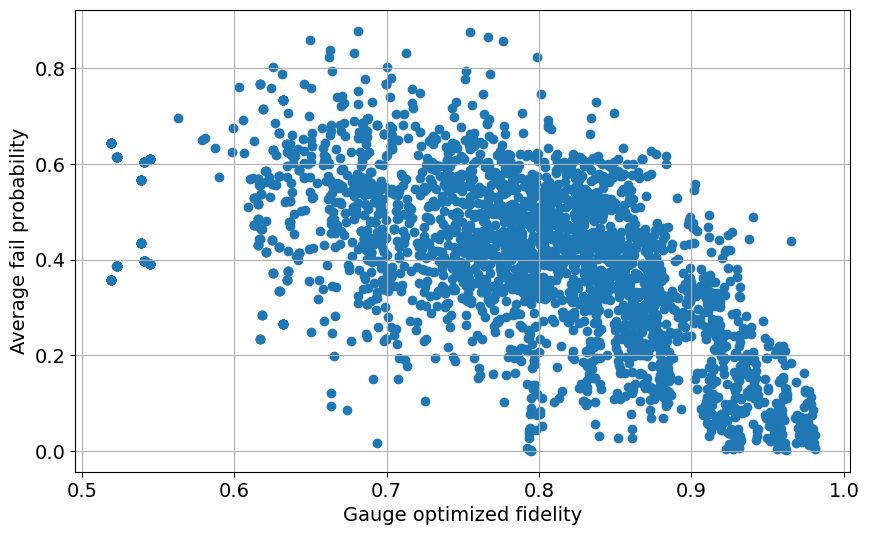

In [81]:
plt.scatter(F,P_avg)
# plt.plot([min(F),max(F)],[min(F),max(F)],color = 'C1')
plt.xlabel('Gauge optimized fidelity')
plt.ylabel('Average fail probability')
plt.grid()
# plt.axhline(y=0.7,color='k')

In [82]:
# Convert to PyTorch tensors
X = torch.tensor(P_train, dtype=torch.float32)   # inputs: 3 probabilities
y = torch.tensor(F_train, dtype=torch.float32).unsqueeze(1)  # output: fidelity


dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

model = nn.Sequential(
    nn.Linear(3, 256),
    nn.GELU(),
    nn.Linear(256, 256),
    nn.GELU(),
    nn.Linear(256, 128),
    nn.GELU(),
    nn.Linear(128, 1)
)


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.5, patience=200
)


losses = []
# -----------------------------
# Training loop
# -----------------------------
epochs = 2000
for epoch in range(epochs):
    for xb, yb in dataloader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        scheduler.step(loss)

    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")


Epoch 10, Loss: 0.008297
Epoch 20, Loss: 0.005684
Epoch 30, Loss: 0.007241
Epoch 40, Loss: 0.006648
Epoch 50, Loss: 0.006992
Epoch 60, Loss: 0.005332
Epoch 70, Loss: 0.007771
Epoch 80, Loss: 0.008912
Epoch 90, Loss: 0.007886
Epoch 100, Loss: 0.006631
Epoch 110, Loss: 0.005056
Epoch 120, Loss: 0.005704
Epoch 130, Loss: 0.006444
Epoch 140, Loss: 0.005542
Epoch 150, Loss: 0.006699
Epoch 160, Loss: 0.008473
Epoch 170, Loss: 0.008541
Epoch 180, Loss: 0.005691
Epoch 190, Loss: 0.012527
Epoch 200, Loss: 0.004718
Epoch 210, Loss: 0.005771
Epoch 220, Loss: 0.007092
Epoch 230, Loss: 0.006318
Epoch 240, Loss: 0.005205
Epoch 250, Loss: 0.003552
Epoch 260, Loss: 0.003909
Epoch 270, Loss: 0.008168
Epoch 280, Loss: 0.005164
Epoch 290, Loss: 0.006758
Epoch 300, Loss: 0.005504
Epoch 310, Loss: 0.008499
Epoch 320, Loss: 0.006907
Epoch 330, Loss: 0.010820
Epoch 340, Loss: 0.008773
Epoch 350, Loss: 0.007754
Epoch 360, Loss: 0.006237
Epoch 370, Loss: 0.008247
Epoch 380, Loss: 0.005326
Epoch 390, Loss: 0.00

In [83]:
pred = model(X)
print(pred.std(), y.std())


tensor(0.0713, grad_fn=<StdBackward0>) tensor(0.1094)


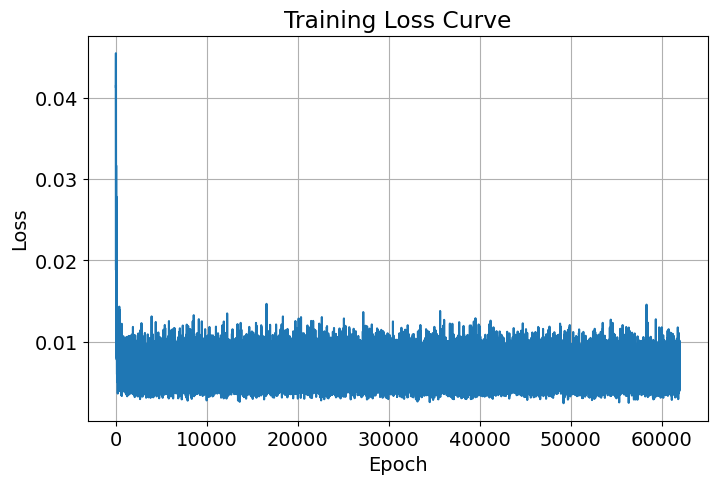

In [84]:
plt.figure(figsize=(8,5))
plt.plot(losses[50:])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()

In [85]:
baseline = ((y - y.mean())**2).mean()
print("Baseline MSE:", baseline.item())


Baseline MSE: 0.011961650103330612


In [86]:
# Test prediction
F_predicted = []
for P in P_test:
    _P_test_tensor = torch.tensor(P).unsqueeze(0)  # Batch dimension (1 sample)
    _prediction = model(_P_test_tensor).detach().numpy().flatten()
    F_predicted.append(_prediction)

/tmp/ipykernel_12505/1514220721.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([min(F_test), max(F_test)], [min(F_test), max(F_test)], 'r--', color='C1', label='Ideal 1:1 Line')


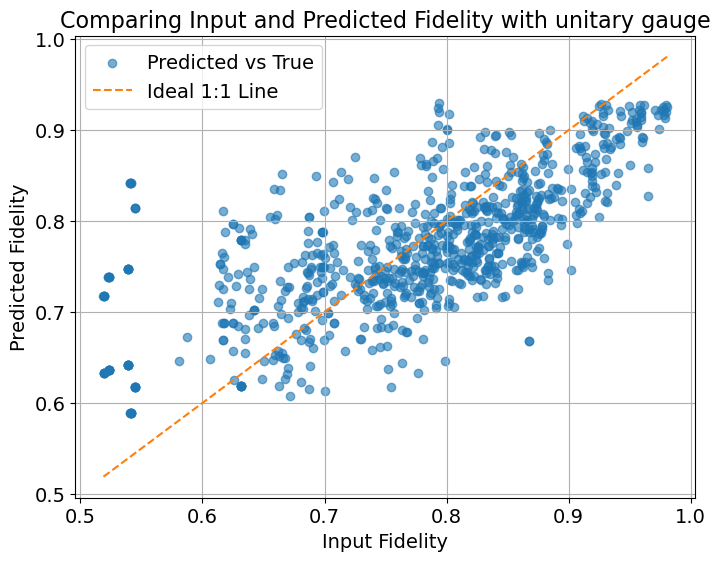

In [87]:
# -----------------------------
# Plot results
# -----------------------------
plt.figure(figsize=(8, 6))

# Scatter plot of true vs predicted fidelities
plt.scatter(F_test, F_predicted, label='Predicted vs True', alpha=0.6)

# Plot ideal 1:1 line (perfect prediction)
plt.plot([min(F_test), max(F_test)], [min(F_test), max(F_test)], 'r--', color='C1', label='Ideal 1:1 Line')

# Labels and title
plt.xlabel("Input Fidelity", fontsize=14)
plt.ylabel("Predicted Fidelity", fontsize=14)
plt.title("Comparing Input and Predicted Fidelity with unitary gauge", fontsize=16)

# Show grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.show()